In [1]:
%load_ext autoreload
%autoreload 2

In [3]:

import sys
sys.path.append("/n/home12/binxuwang/Github/mini_edm")
sys.path.append("/n/home12/binxuwang/Github/DiffusionReasoning")
sys.path.append("/n/home12/binxuwang/Github/DiT")
import os
import json
import time
from os.path import join
import pickle as pkl
import torch
import torch as th
from tqdm import tqdm
import numpy as np
import einops
import seaborn as sns
import matplotlib.pyplot as plt
from easydict import EasyDict as edict
plt.rcParams['figure.dpi'] = 72
plt.rcParams['figure.figsize'] = [6.0, 4.0]
plt.rcParams['figure.edgecolor'] = (1, 1, 1, 0)
plt.rcParams['figure.facecolor'] = (1, 1, 1, 0)
# vector graphics type
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

from train_edm import create_model, edm_sampler, EDM
from edm_utils import edm_sampler_inpaint, create_edm, get_default_config, create_edm_new
# from rule_utils import get_rule_img, get_obj_list, get_rule_list
# from rule_utils import check_consistent
from rule_new_utils import check_r3_r2_batch
from dataset_utils import train_data2attr_tsr,load_raw_data,load_PGM_abstract
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader, TensorDataset
from stats_plot_utils import saveallforms

import circuit_toolkit
print(circuit_toolkit.__file__)
from circuit_toolkit.layer_hook_utils import print_specific_layer, get_module_name_shapes, featureFetcher_module

def infer_rule_from_sample_batch(sample_batch):
    # if not int convert to int
    sample_batch = sample_batch.round().int()
    sample_batch = sample_batch.view(-1, 3, 3, 3, 9) 
    sample_batch = einops.rearrange(sample_batch, 
        "B attr row h (panel w) -> B row panel (h w) attr", 
        panel=3, w=3, h=3, attr=3)
    r3_list, r2_list, rule_col = check_r3_r2_batch(sample_batch)
    return r3_list, r2_list, rule_col


/n/home12/binxuwang/Github/circuit_toolkit/circuit_toolkit/__init__.py


### Data for obtaining repr

In [4]:
DATASET = "RAVEN10_abstract"
train_attrs = np.load("/n/home12/binxuwang/Github/DiffusionReasoning/attr_all.npy")
train_attrs = th.from_numpy(train_attrs).to(int)

if DATASET == "RAVEN10_abstract":
    in_channels = 3
    dataset_Xmean = th.tensor([1.5, 2.5, 2.5]).view(1, 3, 1, 1).to("cuda")
    dataset_Xstd = th.tensor([2.5, 3.5, 3.5]).view(1, 3, 1, 1).to("cuda")
    train_row_img = einops.rearrange(train_attrs, 'c s pnl (H W) att -> c s att H (pnl W)', H=3, W=3, att=3, pnl=3)
    train_sample_img = einops.rearrange(train_row_img, 'c (S R) att H W -> c S att (R H) W', R=3,att=3, H=3, W=9)
elif DATASET == "RAVEN10_abstract_onehot":
    in_channels = 27
    dataset_Xmean = th.tensor([0.5, ]).view(1, 1, 1, 1)
    dataset_Xstd = th.tensor([0.5, ]).view(1, 1, 1, 1)
    raise NotImplementedError("RAVEN10_abstract_onehot not implemented.")
    # use the one-hot encoding
labels_tsr = th.arange(len(train_sample_img)).to(int).view(-1,1).repeat(1, train_sample_img.shape[1])

X_train = train_sample_img[:, :3000]
y_train = labels_tsr[:, :3000]
X_test = train_sample_img[:, 3000:]
y_test = labels_tsr[:, 3000:]
X_train = X_train.reshape(-1, 3, 9, 9)
y_train = y_train.reshape(-1)
X_test = X_test.reshape(-1, 3, 9, 9)
y_test = y_test.reshape(-1)
print(X_train.shape, y_train.shape)
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

torch.Size([120000, 3, 9, 9]) torch.Size([120000])


### Load model ckpt

In [5]:
config_mapping = {
    "WideBlnrX3_new_RAVEN10_abstract_20240315-1327": 
        # --layers_per_block 2 --model_channels 128 --channel_mult 1 2 4 --attn_resolutions 9 3 --train_batch_size 256 --spatial_matching bilinear
        dict(layers_per_block=2, model_channels=128, channel_mult=[1, 2, 4], attn_resolutions=[9, 3], spatial_matching="bilinear"),
    "WideBlnrX3_new_RAVEN10_abstract_20240412-1347":
        dict(layers_per_block=2, model_channels=128, channel_mult=[1, 2, 4], attn_resolutions=[9, 3], spatial_matching="bilinear"),
    "BigBlnrX3_new_RAVEN10_abstract_20240412-0143":
        # --layers_per_block 3 --model_channels 192 --channel_mult 1 2 4 --attn_resolutions 9 3 --train_batch_size 256 --spatial_matching bilinear
        dict(layers_per_block=3, model_channels=192, channel_mult=[1, 2, 4], attn_resolutions=[9, 3], spatial_matching="bilinear"),
    "WideBlnrX3_new_noattn_RAVEN10_abstract_20240412-1254":
        # --layers_per_block 2 --model_channels 128 --channel_mult 1 2 4 --attn_resolutions 0   --train_batch_size 256 --spatial_matching bilinear
        dict(layers_per_block=2, model_channels=128, channel_mult=[1, 2, 4], attn_resolutions=[0], spatial_matching="bilinear"),
    "BaseBlnrX3_new_RAVEN10_abstract_20240313-1736": 
        # --layers_per_block 1 --model_channels 64  --channel_mult 1 2 4 --attn_resolutions 9 3 --train_batch_size 256 --spatial_matching bilinear
        dict(layers_per_block=1, model_channels=64, channel_mult=[1, 2, 4], attn_resolutions=[9, 3], spatial_matching="bilinear"),
}

In [8]:
expname = "WideBlnrX3_new_RAVEN10_abstract_20240412-1347"
epoch = 999999

In [9]:
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps"
expdir = join(exproot, expname)
ckptdir = join(expdir, "checkpoints")
repr_expdir = join(expdir, "repr_classifier")
os.makedirs(repr_expdir, exist_ok=True)
device = "cuda"
config_ft = get_default_config(DATASET, **config_mapping[expname])
# PC_dim = 1024
# # noPCA = False
# noPCA = True
use_ema = True
if epoch == -1:
    # use random initialization if epoch is -1
    edm, model_EDM = create_edm_new(None, config_ft, device) 
    ckpt_str = "ckptRNDINIT"
    print("Random initialization")
else:
    ckpt_path = join(ckptdir, f"ema_{epoch}.pth")
    edm, model_EDM = create_edm_new(ckpt_path, config_ft, device) 
    ckpt_str = f"ckpt{epoch:07d}EMA"
    print(f"Loaded {ckpt_str}: from {ckpt_path}, use_ema: {use_ema}")

model_EDM.to("cuda").eval();

Loaded ckpt0999999EMA: from /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps/WideBlnrX3_new_RAVEN10_abstract_20240412-1347/checkpoints/ema_999999.pth, use_ema: True


In [165]:
t_scalars = [1]#[0.1]
fetcher = featureFetcher_module()
record_module_list = ["input",
               'enc.9x9_conv',
                'enc.3x3_down',
                'enc.1x1_down',
                'dec.1x1_in0',
                'dec.1x1_in1',
                'dec.3x3_up',
                'dec.9x9_up',
                "dec.9x9_aux_norm",
                "dec.9x9_aux_conv", ]
# for blockname in list(model_EDM.enc):
#     if f"enc.{blockname}" in record_module_list:
#         fetcher.record_module(model_EDM.enc[blockname], target_name=f"enc.{blockname}")
# for blockname in list(model_EDM.dec):
#     if f"dec.{blockname}" in record_module_list:
#         fetcher.record_module(model_EDM.dec[blockname], target_name=f"dec.{blockname}")

for blockname in list(edm.ema.enc):
    if f"enc.{blockname}" in record_module_list:
        fetcher.record_module(edm.ema.enc[blockname], target_name=f"enc.{blockname}")
for blockname in list(edm.ema.dec):
    if f"dec.{blockname}" in record_module_list:
        fetcher.record_module(edm.ema.dec[blockname], target_name=f"dec.{blockname}")

for t_scalar in t_scalars: # 0.3, 0.5, 0.7, 0.9, 1.0, 0.05, 0.02, 0.1
    t_str = str(t_scalar).replace('.', '_')
    t_beg = time.time()
    train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=False, drop_last=False)
    test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False, drop_last=False)
    feature_col = defaultdict(list)
    for X_batch, y_batch in tqdm(train_loader):
        t_vec = th.ones(X_batch.shape[0], dtype=torch.float, device="cuda") * t_scalar
        X_batch_norm = (X_batch.cuda().float() - dataset_Xmean) / dataset_Xstd
        with th.no_grad():
            # model_EDM(X_batch_norm, t_vec, None)
            edm(X_batch_norm, t_vec, labels=None, use_ema=True)
        feature_col["input"].append(X_batch.float())
        for key, activations in fetcher.activations.items():
            feature_col[key].append(activations)
    for key in feature_col.keys():
        feature_col[key] = th.cat(feature_col[key], dim=0)
        print(key, feature_col[key].shape)

    feature_col_test = defaultdict(list)
    for X_batch, y_batch in tqdm(test_loader):
        t_vec = th.ones(X_batch.shape[0], dtype=torch.float, device="cuda") * t_scalar
        X_batch_norm = (X_batch.cuda().float() - dataset_Xmean) / dataset_Xstd
        with th.no_grad():
            # model_EDM.forward(X_batch_norm, t_vec, None)
            edm(X_batch_norm, t_vec, labels=None, use_ema=True)
            
        feature_col_test["input"].append(X_batch.float())
        for key, activations in fetcher.activations.items():
            feature_col_test[key].append(activations)
            
    for key in feature_col_test.keys():
        feature_col_test[key] = th.cat(feature_col_test[key], dim=0)
        print(key, feature_col_test[key].shape)
    th.cuda.empty_cache() 
    t_feat = time.time()
    print(f"Feature extraction time: {t_feat - t_beg:.2f}")

100%|██████████| 59/59 [00:39<00:00,  1.48it/s]


input torch.Size([120000, 3, 9, 9])
enc.9x9_conv torch.Size([120000, 128, 9, 9])
enc.3x3_down torch.Size([120000, 128, 3, 3])
enc.1x1_down torch.Size([120000, 256, 1, 1])
dec.1x1_in0 torch.Size([120000, 512, 1, 1])
dec.1x1_in1 torch.Size([120000, 512, 1, 1])
dec.3x3_up torch.Size([120000, 512, 1, 1])
dec.9x9_up torch.Size([120000, 256, 7, 7])
dec.9x9_aux_norm torch.Size([120000, 128, 9, 9])
dec.9x9_aux_conv torch.Size([120000, 3, 9, 9])


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


input torch.Size([40000, 3, 9, 9])
enc.9x9_conv torch.Size([40000, 128, 9, 9])
enc.3x3_down torch.Size([40000, 128, 3, 3])
enc.1x1_down torch.Size([40000, 256, 1, 1])
dec.1x1_in0 torch.Size([40000, 512, 1, 1])
dec.1x1_in1 torch.Size([40000, 512, 1, 1])
dec.3x3_up torch.Size([40000, 512, 1, 1])
dec.9x9_up torch.Size([40000, 256, 7, 7])
dec.9x9_aux_norm torch.Size([40000, 128, 9, 9])
dec.9x9_aux_conv torch.Size([40000, 3, 9, 9])
Feature extraction time: 57.34


### Train linear classifier on latent

In [21]:
from repr_probe_lib import fit_SGD_linear_classifier

In [117]:
layerkey = "dec.3x3_up"
repr_mat = feature_col[layerkey]
repr_mat_test = feature_col_test[layerkey]
repr_mat = repr_mat.view(repr_mat.shape[0], -1)
repr_mat_test = repr_mat_test.view(repr_mat_test.shape[0], -1)
clsf_model2, results = fit_SGD_linear_classifier(repr_mat, y_train, repr_mat_test, y_test, num_classes=40, 
                              batch_size=None, num_epochs=5000, 
                              learning_rate = 0.0005, print_every=100, eval_every=500,)

Epoch [1/5000], Loss: 3.7035, Accuracy: 0.0286
Epoch [100/5000], Loss: 3.0173, Accuracy: 0.5977
Epoch [200/5000], Loss: 2.5251, Accuracy: 0.6688
Epoch [300/5000], Loss: 2.1644, Accuracy: 0.6977
Epoch [400/5000], Loss: 1.8922, Accuracy: 0.7184
Epoch [500/5000], Loss: 1.6815, Accuracy: 0.7346
Test Accuracy: 0.7346
Epoch [600/5000], Loss: 1.5148, Accuracy: 0.7487
Epoch [700/5000], Loss: 1.3805, Accuracy: 0.7604
Epoch [800/5000], Loss: 1.2705, Accuracy: 0.7708
Epoch [900/5000], Loss: 1.1790, Accuracy: 0.7796
Epoch [1000/5000], Loss: 1.1018, Accuracy: 0.7876
Test Accuracy: 0.7877
Epoch [1100/5000], Loss: 1.0359, Accuracy: 0.7946
Epoch [1200/5000], Loss: 0.9790, Accuracy: 0.8013
Epoch [1300/5000], Loss: 0.9293, Accuracy: 0.8069
Epoch [1400/5000], Loss: 0.8856, Accuracy: 0.8116
Epoch [1500/5000], Loss: 0.8469, Accuracy: 0.8160
Test Accuracy: 0.8137
Epoch [1600/5000], Loss: 0.8122, Accuracy: 0.8206
Epoch [1700/5000], Loss: 0.7811, Accuracy: 0.8245
Epoch [1800/5000], Loss: 0.7529, Accuracy: 0.8

In [166]:
layerkey = "enc.1x1_down"
repr_mat = feature_col[layerkey]
repr_mat_test = feature_col_test[layerkey]
repr_mat = repr_mat.view(repr_mat.shape[0], -1)
repr_mat_test = repr_mat_test.view(repr_mat_test.shape[0], -1)
clsf_model, results = fit_SGD_linear_classifier(repr_mat, y_train, repr_mat_test, y_test, num_classes=40, 
                              batch_size=None, num_epochs=5000, 
                              learning_rate = 0.0005, print_every=100, eval_every=500,)

Epoch [1/5000], Loss: 3.7179, Accuracy: 0.0198
Epoch [100/5000], Loss: 2.7213, Accuracy: 0.6194
Epoch [200/5000], Loss: 2.0661, Accuracy: 0.6867
Epoch [300/5000], Loss: 1.6605, Accuracy: 0.7133
Epoch [400/5000], Loss: 1.4039, Accuracy: 0.7312
Epoch [500/5000], Loss: 1.2330, Accuracy: 0.7438
Test Accuracy: 0.7416
Epoch [600/5000], Loss: 1.1125, Accuracy: 0.7546
Epoch [700/5000], Loss: 1.0235, Accuracy: 0.7631
Epoch [800/5000], Loss: 0.9548, Accuracy: 0.7708
Epoch [900/5000], Loss: 0.9002, Accuracy: 0.7764
Epoch [1000/5000], Loss: 0.8556, Accuracy: 0.7824
Test Accuracy: 0.7797
Epoch [1100/5000], Loss: 0.8183, Accuracy: 0.7870
Epoch [1200/5000], Loss: 0.7866, Accuracy: 0.7910
Epoch [1300/5000], Loss: 0.7591, Accuracy: 0.7949
Epoch [1400/5000], Loss: 0.7352, Accuracy: 0.7983
Epoch [1500/5000], Loss: 0.7139, Accuracy: 0.8017
Test Accuracy: 0.7973
Epoch [1600/5000], Loss: 0.6950, Accuracy: 0.8048
Epoch [1700/5000], Loss: 0.6779, Accuracy: 0.8079
Epoch [1800/5000], Loss: 0.6624, Accuracy: 0.8

In [116]:
layerkey = "enc.1x1_down"
repr_mat = feature_col[layerkey]
repr_mat_test = feature_col_test[layerkey]
repr_mat = repr_mat.view(repr_mat.shape[0], -1)
repr_mat_test = repr_mat_test.view(repr_mat_test.shape[0], -1)
clsf_model, results = fit_SGD_linear_classifier(repr_mat, y_train, repr_mat_test, y_test, num_classes=40, 
                              batch_size=None, num_epochs=5000, 
                              learning_rate = 0.0005, print_every=100, eval_every=500,)

Epoch [1/5000], Loss: 3.7182, Accuracy: 0.0233
Epoch [100/5000], Loss: 2.7426, Accuracy: 0.7152
Epoch [200/5000], Loss: 2.0071, Accuracy: 0.8132
Epoch [300/5000], Loss: 1.5068, Accuracy: 0.8415
Epoch [400/5000], Loss: 1.1802, Accuracy: 0.8576
Epoch [500/5000], Loss: 0.9648, Accuracy: 0.8686
Test Accuracy: 0.8680
Epoch [600/5000], Loss: 0.8173, Accuracy: 0.8773
Epoch [700/5000], Loss: 0.7121, Accuracy: 0.8839
Epoch [800/5000], Loss: 0.6339, Accuracy: 0.8887
Epoch [900/5000], Loss: 0.5740, Accuracy: 0.8929
Epoch [1000/5000], Loss: 0.5267, Accuracy: 0.8963
Test Accuracy: 0.8944
Epoch [1100/5000], Loss: 0.4885, Accuracy: 0.8993
Epoch [1200/5000], Loss: 0.4570, Accuracy: 0.9019
Epoch [1300/5000], Loss: 0.4306, Accuracy: 0.9043
Epoch [1400/5000], Loss: 0.4081, Accuracy: 0.9063
Epoch [1500/5000], Loss: 0.3887, Accuracy: 0.9082
Test Accuracy: 0.9064
Epoch [1600/5000], Loss: 0.3719, Accuracy: 0.9102
Epoch [1700/5000], Loss: 0.3571, Accuracy: 0.9114
Epoch [1800/5000], Loss: 0.3439, Accuracy: 0.9

In [118]:
clsf_model.fc.weight.shape, clsf_model.fc.bias.shape

(torch.Size([40, 256]), torch.Size([40]))

### See latent vector prediction during sampling

In [54]:
@torch.no_grad()
def edm_sampler_with_fetcher(
    edm, latents, class_labels=None,
    num_steps=18, sigma_min=0.002, sigma_max=80, rho=7,
    use_ema=True, feature_col=defaultdict(list), fetcher=None, 
):
    # Adjust noise levels based on what's supported by the network.
    sigma_min = max(sigma_min, edm.sigma_min)
    sigma_max = min(sigma_max, edm.sigma_max)

    # Time step discretization.
    step_indices = torch.arange(num_steps, dtype=torch.float64, device=latents.device)
    t_steps = (sigma_max ** (1 / rho) + step_indices / (num_steps - 1) * (sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho
    t_steps = torch.cat([edm.round_sigma(t_steps), torch.zeros_like(t_steps[:1])]) # t_N = 0

    # Main sampling loop.
    x_next = latents.to(torch.float64) * t_steps[0]
    for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])): # 0, ..., N-1
        x_hat = x_next
        t_hat = t_cur
        
        # Euler step.
        denoised = edm(x_hat, t_hat, class_labels, use_ema=use_ema).to(torch.float64)
        d_cur = (x_hat - denoised) / t_hat
        x_next = x_hat + (t_next - t_hat) * d_cur
        for key, activations in fetcher.activations.items():
            feature_col[key].append(activations)
        
        # Apply 2nd order correction.
        if i < num_steps - 1:
            denoised = edm(x_next, t_next, class_labels, use_ema=use_ema).to(torch.float64)
            d_prime = (x_next - denoised) / t_next
            x_next = x_hat + (t_next - t_hat) * (0.5 * d_cur + 0.5 * d_prime)
            for key, activations in fetcher.activations.items():
                feature_col[key].append(activations)
            
    return x_next, feature_col

In [ ]:
# record_module_list = ["input",
#                'enc.9x9_conv',
#                 'enc.3x3_down',
#                 'enc.1x1_down',
#                 'dec.1x1_in0',
#                 'dec.1x1_in1',
#                 'dec.3x3_up',
#                 'dec.9x9_up',
#                 "dec.9x9_aux_norm",
#                 "dec.9x9_aux_conv", ]
# fetcher_new = featureFetcher_module()
# for blockname in list(model_EDM.enc):
#     if f"enc.{blockname}" in record_module_list:
#         fetcher_new.record_module(model_EDM.enc[blockname], target_name=f"enc.{blockname}")
# for blockname in list(model_EDM.dec):
#     if f"dec.{blockname}" in record_module_list:
#         fetcher_new.record_module(model_EDM.dec[blockname], target_name=f"dec.{blockname}")

In [119]:
feature_col_sampler = defaultdict(list)
latents = torch.randn(512, 3, 9, 9).to(device)
samples, feature_col_sampler = edm_sampler_with_fetcher(edm, latents, num_steps=40, feature_col=feature_col_sampler, fetcher=fetcher)
samples = samples * dataset_Xstd + dataset_Xmean
r3_list, r2_list, rule_col = infer_rule_from_sample_batch(samples.cpu())
sum([len(r3)>0 for r3 in r3_list]), sum([len(r2)>0 for r2 in r2_list])

(261, 100)

In [175]:
hidden_repr_traj = th.stack(feature_col_sampler["enc.1x1_down"], dim=0)
print(hidden_repr_traj.shape)
hidden_repr_traj = hidden_repr_traj.squeeze(-1).squeeze(-1)

torch.Size([79, 512, 256, 1, 1])


In [176]:
C3mask = [len(r3)>0 for r3 in r3_list]
C3mask = np.array(C3mask).astype(bool)
C3correct_rule = [r3[0] for r3 in r3_list if len(r3)>0]
C3correct_rule = th.tensor(C3correct_rule).long()
hidden_repr_traj_C3 = hidden_repr_traj[:, C3mask, ]
print(hidden_repr_traj_C3.shape, C3correct_rule.shape)

torch.Size([79, 261, 256]) torch.Size([261])


In [177]:
with torch.no_grad():
    logits = clsf_model(hidden_repr_traj_C3.cuda())
probs = torch.nn.functional.softmax(logits, dim=-1)
pred = th.argmax(probs, dim=-1).cpu()
    

In [132]:
correct_rule_prob_traj = torch.gather(probs.cpu(), 2, C3correct_rule.view(1, -1, 1).repeat(79,1,1))
rule_acc_traj = (pred == C3correct_rule.view(1, -1)).float()
correct_rule_prob_traj = correct_rule_prob_traj.squeeze(-1)
print(correct_rule_prob_traj.shape)

torch.Size([79, 261])


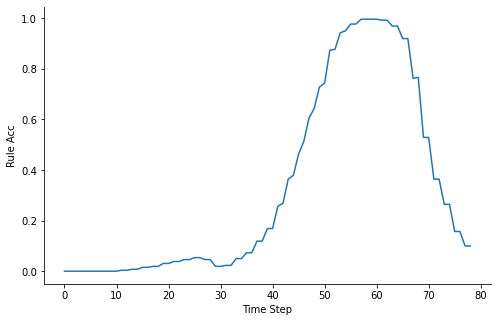

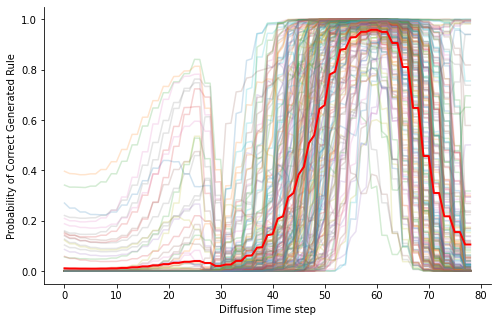

In [178]:
plt.figure(figsize=(8, 5))
plt.plot(rule_acc_traj.mean(1), label="Rule Acc")
plt.xlabel("Time Step")
plt.ylabel("Rule Acc")
plt.show()
plt.figure(figsize=(8, 5))
plt.plot(correct_rule_prob_traj.numpy(), alpha=0.2);
plt.plot(correct_rule_prob_traj.mean(dim=1).squeeze(-1).numpy(), color='red', linewidth=2);
plt.xlabel("Diffusion Time step")
plt.ylabel("Probability of Correct Generated Rule")
plt.show()


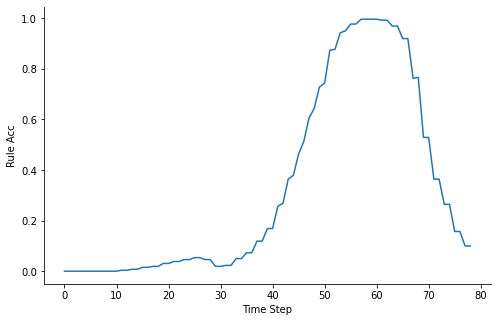

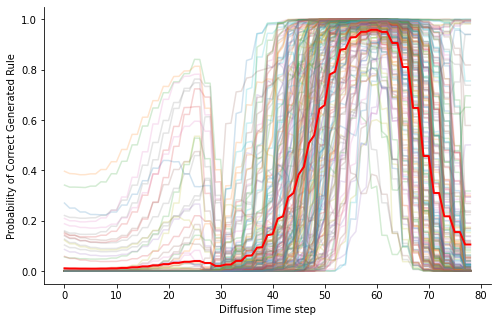

In [135]:
plt.figure(figsize=(8, 5))
plt.plot(rule_acc_traj.mean(1), label="Rule Acc")
plt.xlabel("Time Step")
plt.ylabel("Rule Acc")
plt.show()
plt.figure(figsize=(8, 5))
plt.plot(correct_rule_prob_traj.numpy(), alpha=0.2);
plt.plot(correct_rule_prob_traj.mean(dim=1).squeeze(-1).numpy(), color='red', linewidth=2);
plt.xlabel("Diffusion Time step")
plt.ylabel("Probability of Correct Generated Rule")
plt.show()


### What about other wrong 

In [137]:
hidden_repr_traj.shape

torch.Size([79, 512, 256, 1, 1])

In [167]:
C3mask = [len(r3)>0 for r3 in r3_list]
C3mask = np.array(C3mask).astype(bool)
C3correct_rule = [r3[0] for r3 in r3_list if len(r3)>0]
C3correct_rule = th.tensor(C3correct_rule).long()
C2mask = [len(r2)>0 for r2 in r2_list]
C2mask = np.array(C2mask).astype(bool)
Nonmask = np.logical_not(C3mask | C2mask)
with torch.no_grad():
    logits = clsf_model(hidden_repr_traj.squeeze().squeeze().cuda()).cpu()
probs = torch.nn.functional.softmax(logits, dim=-1)
pred = th.argmax(probs, dim=-1)
entropy = entropy_from_logits(logits)


In [171]:
entropy = entropy_from_logits(logits)


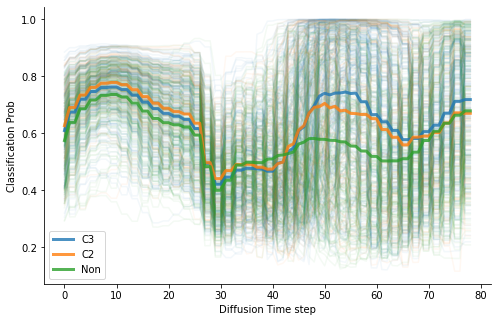

In [168]:
plt.figure(figsize=(8, 5))
plt.plot(probs[:, C3mask].max(dim=-1).values, color="C0", alpha=0.05) # label="C3", 
plt.plot(probs[:, C2mask].max(dim=-1).values, color="C1", alpha=0.05) # label="C2", 
plt.plot(probs[:, Nonmask].max(dim=-1).values, color="C2", alpha=0.05) # label="Non", 
plt.plot(probs[:, C3mask].max(dim=-1).values.mean(dim=1), label="C3", color="C0", lw=3, alpha=0.8)
plt.plot(probs[:, C2mask].max(dim=-1).values.mean(dim=1), label="C2", color="C1", lw=3, alpha=0.8)
plt.plot(probs[:, Nonmask].max(dim=-1).values.mean(dim=1), label="Non", color="C2", lw=3, alpha=0.8)
plt.ylabel("Classification Prob")
plt.xlabel("Diffusion Time step")
plt.legend()
plt.show()

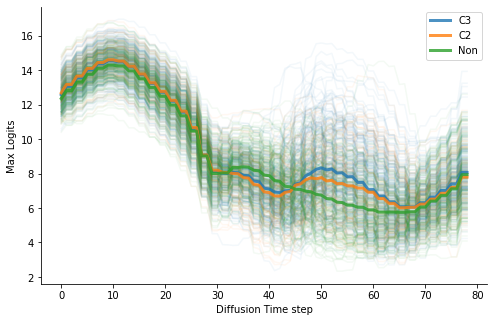

In [169]:
plt.figure(figsize=(8, 5))
plt.plot(logits[:, C3mask].max(dim=-1).values, color="C0", alpha=0.05) # label="C3", 
plt.plot(logits[:, C2mask].max(dim=-1).values, color="C1", alpha=0.05) # label="C2", 
plt.plot(logits[:, Nonmask].max(dim=-1).values, color="C2", alpha=0.05) # label="Non", 
plt.plot(logits[:, C3mask].max(dim=-1).values.mean(dim=1), label="C3", color="C0", lw=3, alpha=0.8)
plt.plot(logits[:, C2mask].max(dim=-1).values.mean(dim=1), label="C2", color="C1", lw=3, alpha=0.8)
plt.plot(logits[:, Nonmask].max(dim=-1).values.mean(dim=1), label="Non", color="C2", lw=3, alpha=0.8)
plt.ylabel("Max Logits")
plt.xlabel("Diffusion Time step")
plt.legend()
plt.show()

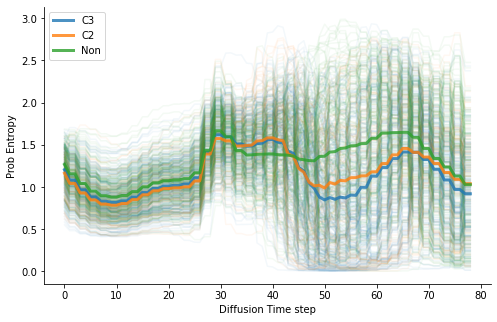

In [172]:
entropy = entropy_from_logits(logits)
plt.figure(figsize=(8, 5))
plt.plot(entropy[:, C3mask], color="C0", alpha=0.05) # label="C3", 
plt.plot(entropy[:, C2mask], color="C1", alpha=0.05) # label="C2", 
plt.plot(entropy[:, Nonmask], color="C2", alpha=0.05) # label="Non", 
plt.plot(entropy[:, C3mask].mean(dim=1), label="C3", color="C0", lw=3, alpha=0.8)
plt.plot(entropy[:, C2mask].mean(dim=1), label="C2", color="C1", lw=3, alpha=0.8)
plt.plot(entropy[:, Nonmask].mean(dim=1), label="Non", color="C2", lw=3, alpha=0.8)
plt.ylabel("Prob Entropy")
plt.xlabel("Diffusion Time step")
plt.legend()
plt.show()

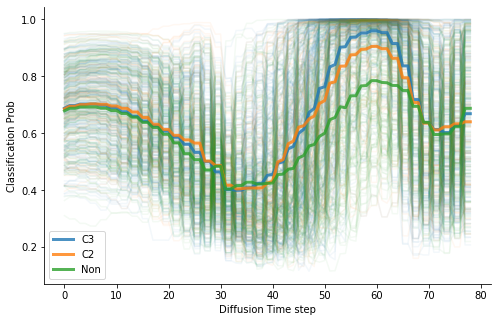

In [162]:
plt.figure(figsize=(8, 5))
plt.plot(probs[:, C3mask].max(dim=-1).values, color="C0", alpha=0.05) # label="C3", 
plt.plot(probs[:, C2mask].max(dim=-1).values, color="C1", alpha=0.05) # label="C2", 
plt.plot(probs[:, Nonmask].max(dim=-1).values, color="C2", alpha=0.05) # label="Non", 
plt.plot(probs[:, C3mask].max(dim=-1).values.mean(dim=1), label="C3", color="C0", lw=3, alpha=0.8)
plt.plot(probs[:, C2mask].max(dim=-1).values.mean(dim=1), label="C2", color="C1", lw=3, alpha=0.8)
plt.plot(probs[:, Nonmask].max(dim=-1).values.mean(dim=1), label="Non", color="C2", lw=3, alpha=0.8)
plt.ylabel("Classification Prob")
plt.xlabel("Diffusion Time step")
plt.legend()
plt.show()

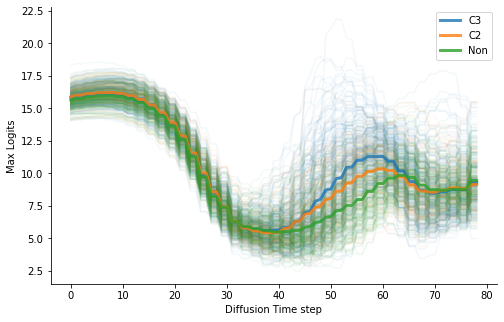

In [157]:
plt.figure(figsize=(8, 5))
plt.plot(logits[:, C3mask].max(dim=-1).values, color="C0", alpha=0.05) # label="C3", 
plt.plot(logits[:, C2mask].max(dim=-1).values, color="C1", alpha=0.05) # label="C2", 
plt.plot(logits[:, Nonmask].max(dim=-1).values, color="C2", alpha=0.05) # label="Non", 
plt.plot(logits[:, C3mask].max(dim=-1).values.mean(dim=1), label="C3", color="C0", lw=3, alpha=0.8)
plt.plot(logits[:, C2mask].max(dim=-1).values.mean(dim=1), label="C2", color="C1", lw=3, alpha=0.8)
plt.plot(logits[:, Nonmask].max(dim=-1).values.mean(dim=1), label="Non", color="C2", lw=3, alpha=0.8)
plt.ylabel("Max Logits")
plt.xlabel("Diffusion Time step")
plt.legend()
plt.show()

In [158]:
import torch as th

def entropy_from_logits(logits, dim=-1):
    # Convert logits to probabilities
    prob = th.nn.functional.softmax(logits, dim=dim)
    # Compute entropy
    entropy = -th.sum(prob * th.log(prob + 1e-9), dim=dim)
    return entropy

def entropy_from_prob(prob, dim=-1):
    # Ensure probabilities are normalized
    prob = prob / prob.sum(dim=dim, keepdim=True)
    # Compute entropy
    entropy = -th.sum(prob * th.log(prob + 1e-9), dim=dim)
    return entropy

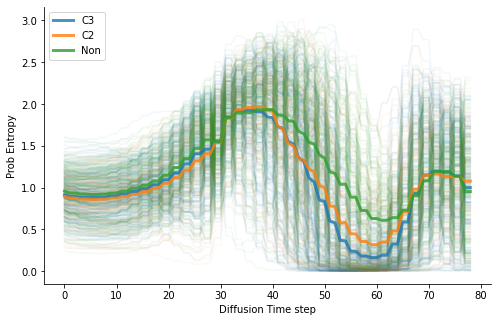

In [161]:
entropy = entropy_from_logits(logits)
plt.figure(figsize=(8, 5))
plt.plot(entropy[:, C3mask], color="C0", alpha=0.05) # label="C3", 
plt.plot(entropy[:, C2mask], color="C1", alpha=0.05) # label="C2", 
plt.plot(entropy[:, Nonmask], color="C2", alpha=0.05) # label="Non", 
plt.plot(entropy[:, C3mask].mean(dim=1), label="C3", color="C0", lw=3, alpha=0.8)
plt.plot(entropy[:, C2mask].mean(dim=1), label="C2", color="C1", lw=3, alpha=0.8)
plt.plot(entropy[:, Nonmask].mean(dim=1), label="Non", color="C2", lw=3, alpha=0.8)
plt.ylabel("Prob Entropy")
plt.xlabel("Diffusion Time step")
plt.legend()
plt.show()

In [ ]:
with torch.no_grad():
    logits = clsf_model(hidden_repr_traj_C3.cuda())
probs = torch.nn.functional.softmax(logits, dim=-1)
pred = th.argmax(probs, dim=-1).cpu()
    

In [ ]:
correct_rule_prob_traj = torch.gather(probs.cpu(), 2, C3correct_rule.view(1, -1, 1).repeat(79,1,1))
rule_acc_traj = (pred == C3correct_rule.view(1, -1)).float()
correct_rule_prob_traj = correct_rule_prob_traj.squeeze(-1)
print(correct_rule_prob_traj.shape)

torch.Size([79, 261])


In [ ]:
list(feature_col_sampler)

['enc.9x9_conv',
 'enc.3x3_down',
 'enc.1x1_down',
 'dec.1x1_in0',
 'dec.1x1_in1',
 'dec.3x3_up',
 'dec.9x9_up',
 'dec.9x9_aux_norm',
 'dec.9x9_aux_conv']

In [44]:
list(feature_col_sampler)

['enc.9x9_conv',
 'enc.3x3_down',
 'enc.1x1_down',
 'dec.1x1_in0',
 'dec.1x1_in1',
 'dec.3x3_up',
 'dec.9x9_up',
 'dec.9x9_aux_norm',
 'dec.9x9_aux_conv']

In [29]:
latents = torch.randn(256, 3, 9, 9).to(device)
samples = edm_sampler(edm, latents, num_steps=40)
samples = samples * dataset_Xstd + dataset_Xmean
r3_list, r2_list, rule_col = infer_rule_from_sample_batch(samples.cpu())

In [30]:
sum([len(r3)>0 for r3 in r3_list]), sum([len(r2)>0 for r2 in r2_list])

(129, 52)